# Image Stitching (Python)

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Stitching Pairs of Images section of MP 3. In main function, we outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- `opencv`
- `numpy`
- `skimage`
- `scipy`

# Common imports

In [1]:
import numpy as np
# import skimage 
from skimage import io
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy
import random

# Helper functions

In [2]:
def imread(fname):
    """
    read image into np array from file
    """
    # return skimage.io.imread(fname)
    return io.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)

def imshow(img):
    """
    show image
    """
    # skimage.io.imshow(img)
    io.imshow(img)
    
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

# Main functions

#### Load images

In [3]:
img1 = imread('./stitch/left.jpg')
img2 = imread('./stitch/right.jpg')

#### Part (3) compute and display the initial SIFT matching result

In [4]:
def get_best_matches(img1, img2, num_matches):
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1, kp2 = np.array(kp1), np.array(kp2)
    
    # Find distance between descriptors in images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')

    # Select num_matches smallest value from dist
    idx = np.argpartition(dist, range(num_matches), axis=None)[:num_matches]

    # Get row & col index of these value
    r, c = divmod(idx, dist.shape[1])

    # Create empty coordinate array
    coord = np.empty((0,4), float)
    # Create empty keypoints array
    kps = np.empty((0,2), object)
    for i in range(len(r)):
        # In each row, first two elements are (x, y) of keypoint on img1,
        # last two elements are (x, y) of keypoint on img2
        coord_entry = np.hstack([kp1[r[i]].pt, kp2[c[i]].pt]).reshape(1,-1)
        # Append coordinate to the coordinate array
        coord = np.append(coord, coord_entry, axis=0)
        # Create keypoints entry
        kps_entry = np.hstack([kp1[r[i]], kp2[c[i]]]).reshape(1,-1)
        # Append keypoints to the keypoints array
        kps = np.append(kps, kps_entry, axis=0)

    assert(kps.shape[0] == coord.shape[0])
    assert(kps.shape[0] == len(r))

    # Return simple coordinates and keypoints pairs
    return coord, kps

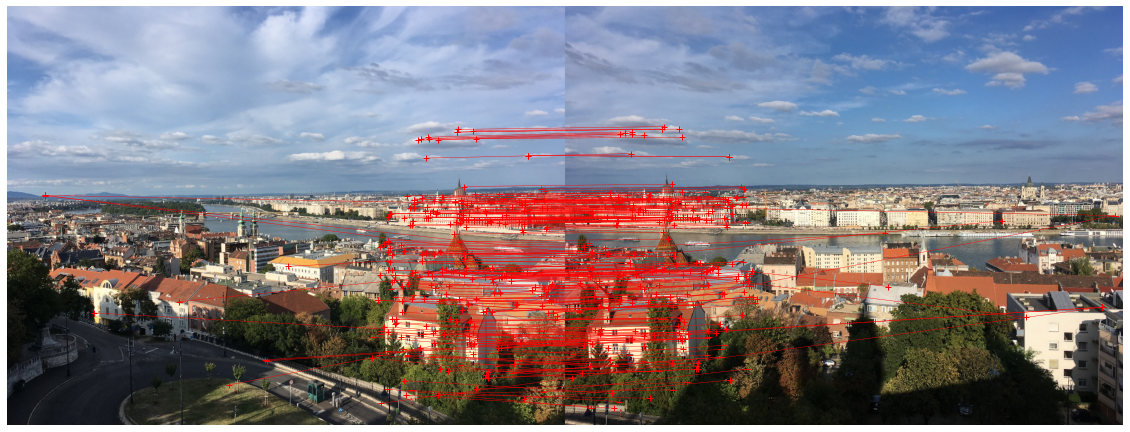

In [5]:
data, kps = get_best_matches(img1, img2, 300)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)
fig.savefig('sift_match.png', bbox_inches='tight')

#### Part (4) performn RANSAC to get the homography and inliers

In [6]:
def compute_homography(l, r):
    """
    write your code to compute homography according to the matches
    l = H.dot(r)
    """
    assert(l.shape == r.shape)
    # Number of data points, should be 4
    num = l.shape[0]
    # Create empty matrix A
    A = np.zeros((num*2, 9))
    # Go over all samples
    for i in range(num):
        # Create horizonatl zero
        zero_t = [0, 0, 0]
        # Creat horizontal x_i
        x_t = np.array([r[i, 0], r[i, 1], 1])
        # Get x'
        x_p = l[i, 0]
        # Get y'
        y_p = l[i, 1]
        # Get even line
        A[2*i] = np.concatenate((zero_t, x_t, -y_p*x_t))
        # Get odd line
        A[2*i+1] = np.concatenate((x_t, zero_t, -x_p*x_t))
    # Do SVD to get V
    U, S, V = np.linalg.svd(A)
    # Use V to get H
    H = V[-1,:].reshape(3,3)
    # Scale H so last element is 1
    H = H / H[-1,-1]

    return H

In [7]:
def ransac(matches, ransac_itr=50, error_thres=0.5):
    """
    write your ransac code to find the best model, inliers, and residuals
    """
    assert(matches.shape[0] >= 4)
    assert(matches.shape[1] == 4)

    # Select a seed for psedo-random for repeatability
    # random.seed(42)

    # Initialize score
    score_thres = 0
    # Repeat RANSAC
    for itr in range(ransac_itr):
        # Randomly select 4 points to start with
        idxs = random.sample(range(matches.shape[0]), 4)
        # Get selected coordinates
        selected = np.array(matches[idxs])
        # Get left image and right image indexes
        l_coord = selected[:,:2]
        r_coord = selected[:,2:]
        # Get homography matrix H from left and right image coordinate
        # project r to l, l = H.dot(r)
        H = compute_homography(l_coord, r_coord)
        # Create a horizontal ones
        ones = np.ones(matches.shape[0])
        # Get true coordinate from left image, and append row of 1 to bottom
        true = np.vstack([matches[:,:2].T, ones])
        # Get source coordinate from right image, and append row of 1 to bottom
        srcs = np.vstack([matches[:,2:].T, ones])
        # Get predicted coordinate, with last row being 1
        pred = np.dot(H, srcs)
        # Get mean squared distance error 
        err = np.sqrt(np.sum(np.square(true - (pred / pred[-1])), axis=0))
        # Score this transformation
        score = np.count_nonzero(err < error_thres)
        # Keep max score
        if (score > score_thres):
            # Update high score
            score_thres = score
            # Update best H matrix
            H_best = H
            # Figure out which item to keep
            keep_idx = np.argwhere(err < error_thres).flatten()
            # Use keep_idx to filter out inliers in right image
            srcs_inliers = srcs[:, keep_idx][:-1].T
            # Use keep_idx to filter out inliers in left image
            true_inliers = true[:, keep_idx][:-1].T
            # Use keep_idx to filter out inliers in residual
            err_inliers = err[keep_idx]
            # Update 4 random choosen coordinates that gives best result
            selected_best = selected

            assert(srcs_inliers.shape == true_inliers.shape)
            assert(err_inliers.shape[0] == srcs_inliers.shape[0])

    return H_best, srcs_inliers, true_inliers, np.average(err_inliers)

Average residual: 0.5092374533970863
Num inliers: 203


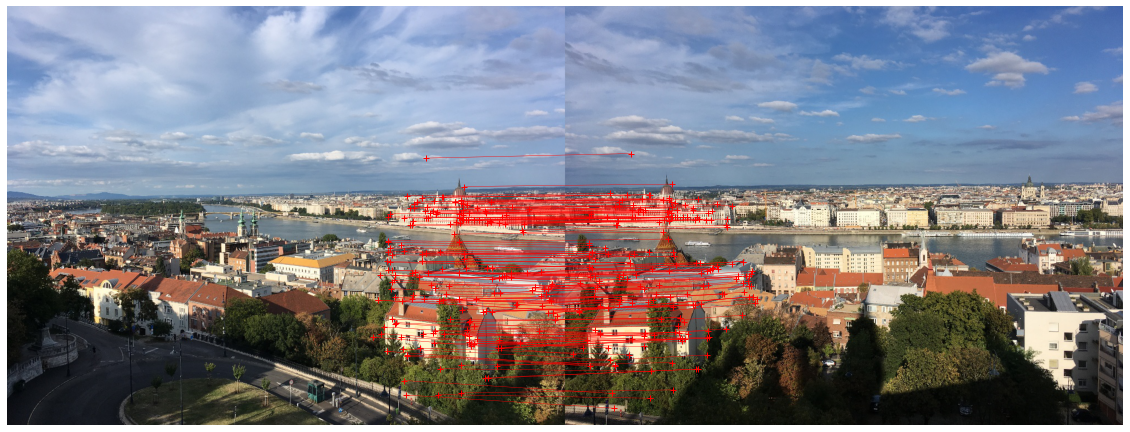

In [8]:
# display the inlier matching, report the average residual
# <YOUR CODE>
# RANSAC!
H, r_inliers, l_inliers, residuals = ransac(data, ransac_itr=500, error_thres=1.0)
# Stack left and right inliers together for display purpose
inliers = np.hstack([l_inliers, r_inliers])

print("Average residual:", residuals)
print("Num inliers:", r_inliers.shape[0])

# Plot and save
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, inliers)
fig.savefig('ransac_match.png', bbox_inches='tight')

#### Part (5) warp images to stitch them together

In [9]:
def warp_images(img1, img2):
    """
    write your code to stitch images together according to the homography
    """
    # <YOUR CODE>
    pass

In [10]:
# display and report the stitching results
# <YOUR CODE>
# cv2.imwrite('stitched_images.jpg', im[:,:,::-1]*255., 
#             [int(cv2.IMWRITE_JPEG_QUALITY), 90])